Comparing the DG method with the Trefftz-DG method on the anisotropic mesh in 1+1 dimensions. 

In [1]:
N = 2
c=2
t_steps = c*N
order = 12
k = 1
D = 2

In [2]:
def MakeMesh():
    import netgen.meshing as ngm
    from netgen.geom2d import unit_square
    
    ngmesh = ngm.Mesh()
    ngmesh.SetGeometry(unit_square)
    ngmesh.dim = 2
    pnums = []
    for i in range(t_steps + 1):
        for j in range(N + 1):
            pnums.append(ngmesh.Add(ngm.MeshPoint(ngm.Pnt(i / t_steps, j / N, 0))))

    foo = ngm.FaceDescriptor(surfnr=1,domin=1,bc=1)
    ngmesh.Add (foo)
    ngmesh.SetMaterial(1, "mat")
    for j in range(t_steps):
        for i in range(N):
            ngmesh.Add(ngm.Element2D(1, [
                                        pnums[i + j * (N + 1)],
                                        pnums[i + 1 + j * (N + 1)],
                                        pnums[i + 1 + (j + 1) * (N + 1)],
                                        pnums[i + (j + 1) * (N + 1)],
                                         ]))
    for i in range(t_steps):
       ngmesh.Add(ngm.Element1D([pnums[N + i * (N + 1)], pnums[N + (i + 1) * (N + 1)]], index=1))
       ngmesh.Add(ngm.Element1D([pnums[0 + i * (N + 1)], pnums[0 + (i + 1) * (N + 1)]], index=1))
    for i in range(N):
       ngmesh.Add(ngm.Element1D([pnums[i], pnums[i + 1]], index=2))
       ngmesh.Add(ngm.Element1D([pnums[i + t_steps * (N + 1)], pnums[i + 1 + t_steps * (N + 1)]], index=2))

    mesh = Mesh(ngmesh)
    return mesh

In [3]:
from ngsolve import *
import scipy 
from trefftzngs import *
import numpy as np
SetHeapSize(100*1000*1000)

truesol =  sin( k*(c*y + x) )#exp(-pow(c*x+y,2)))#
v0 = c*k*cos(k*(c*y+x))#grad(U0)[0]
sig0 = -k*cos(k*(c*y+x))#-grad(U0)[1]


In [4]:
def MakeSystem(truesol,v0,sig0,fes,alpha,beta,gamma=1):
    U = fes.TrialFunction()
    V = fes.TestFunction()

    v = grad(U)[1]
    sig = -grad(U)[0]
    w = grad(V)[1]
    tau = -grad(V)[0]

    vo = grad(U.Other())[1]
    sigo = -grad(U.Other())[0]
    wo = grad(V.Other())[1]
    tauo = -grad(V.Other())[0]

    h = specialcf.mesh_size
    n = specialcf.normal(2)
    n_t = n[1]/Norm(n)
    n_x = n[0]/Norm(n)

    mean_v = 0.5*(v+vo)
    mean_w = 0.5*(w+wo)
    mean_sig = 0.5*(sig+sigo)
    mean_tau = 0.5*(tau+tauo)

    jump_vx = ( v - vo ) * n_x
    jump_wx = ( w - wo ) * n_x
    jump_sigx = ( sig - sigo ) * n_x
    jump_taux = ( tau - tauo ) * n_x

    jump_vt = ( v - vo ) * n_t
    jump_wt = ( w - wo ) * n_t
    jump_sigt = ( sig - sigo ) * n_t
    jump_taut = ( tau - tauo ) * n_t

    jump_Ut = (U - U.Other()) * n_t

    timelike = n_x**2 #IfPos(n_t,0,IfPos(-n_t,0,1)) # n_t=0
    spacelike = n_t**2 #IfPos(n_x,0,IfPos(-n_x,0,1)) # n_x=0

    a = BilinearForm(fes)
    
    # a += SymbolicBFI( spacelike * ( IfPos(n_t,v,vo)*(pow(c,-2)*jump_wt+jump_taux) + IfPos(n_t,sig,sigo)*(jump_wx+jump_taut) ) ,VOL,  skeleton=True ) #space like faces
    a += SymbolicBFI( spacelike * ( IfPos(n_t,v,vo)*(pow(c,-2)*jump_wt) + IfPos(n_t,sig,sigo)*(jump_taut) ) ,VOL,  skeleton=True ) #space like faces, no jump in x since horizontal
    a += SymbolicBFI( timelike 	* ( mean_v*jump_taux + mean_sig*jump_wx + alpha*jump_vx*jump_wx + beta*jump_sigx*jump_taux ) ,VOL, skeleton=True ) #time like faces
    a += SymbolicBFI( spacelike * IfPos(n_t,1,0) * ( pow(c,-2)*v*w + sig*tau ), BND, skeleton=True) #t=T (or *x)
    a += SymbolicBFI( timelike 	* ( sig*n_x*w + alpha*v*w ), BND, skeleton=True) #dirichlet boundary 'timelike'
    a += SymbolicBFI( spacelike * ( gamma * (-n_t*jump_Ut)*IfPos(n_t,V.Other(),V) ) ,VOL,  skeleton=True ) #correction term to recover sol of second order system
    a += SymbolicBFI( spacelike * ( gamma * IfPos(-n_t,1,0) * U*V ) ,BND,  skeleton=True ) #BND correction term to recover sol of second order system
    a.Assemble()

    f = LinearForm(fes)
    f += SymbolicLFI( spacelike * IfPos(-n_t,1,0) *  ( pow(c,-2)*v0*w + sig0*tau ), BND, skeleton=True) #t=0 (or *(1-x))
    f += SymbolicLFI( timelike 	* ( v0 * (alpha*w - tau*n_x) ), BND, skeleton=True) #dirichlet boundary 'timelike'
    f += SymbolicLFI( spacelike * gamma * IfPos(-n_t,1,0) *  ( (truesol)*V ) ,BND,  skeleton=True ) #rhs correction term to recover sol of second order system
    f.Assemble()

    return [a,f]
    # gfu2= GridFunction(fes, name="uDG")
    # gfu2.vec.data = a.mat.Inverse() * f.vec

In [5]:
def MakeL2System(v0,sig0,fes,alpha,beta,gamma=1):
    sig,v = fes.TrialFunction()
    tau,w = fes.TestFunction()

    vo = v.Other()
    sigo = sig.Other()
    wo = w.Other()
    tauo = tau.Other()

    h = specialcf.mesh_size
    n = specialcf.normal(2)
    n_t = n[1]/Norm(n)
    n_x = n[0]/Norm(n)

    mean_v = 0.5*(v+vo)
    mean_w = 0.5*(w+wo)
    mean_sig = 0.5*(sig+sigo)
    mean_tau = 0.5*(tau+tauo)

    jump_vx = ( v - vo ) * n_x
    jump_wx = ( w - wo ) * n_x
    jump_sigx = ( sig - sigo ) * n_x
    jump_taux = ( tau - tauo ) * n_x

    jump_vt = ( v - vo ) * n_t
    jump_wt = ( w - wo ) * n_t
    jump_sigt = ( sig - sigo ) * n_t
    jump_taut = ( tau - tauo ) * n_t

    timelike = n_x**2 #IfPos(n_t,0,IfPos(-n_t,0,1)) # n_t=0
    spacelike = n_t**2 #IfPos(n_x,0,IfPos(-n_x,0,1)) # n_x=0

    a = BilinearForm(fes)
    a += SymbolicBFI(  -v*(grad(tau)[0]+pow(c,-2)*grad(w)[1]) - sig*(grad(tau)[1]+grad(w)[0])  )
    a += SymbolicBFI( spacelike * ( IfPos(n_t,v,vo)*(pow(c,-2)*jump_wt) + IfPos(n_t,sig,sigo)*(jump_taut) ) ,VOL,  skeleton=True ) #space like faces, no jump in x since horizontal
    a += SymbolicBFI( timelike 	* ( mean_v*jump_taux + mean_sig*jump_wx + alpha*jump_vx*jump_wx + beta*jump_sigx*jump_taux ) ,VOL, skeleton=True ) #time like faces
    a += SymbolicBFI( spacelike * IfPos(n_t,1,0) * ( pow(c,-2)*v*w + sig*tau ), BND, skeleton=True) #t=T (or *x)
    a += SymbolicBFI( timelike 	* ( sig*n_x*w + alpha*v*w ), BND, skeleton=True) #dirichlet boundary 'timelike'
    a.Assemble()

    f = LinearForm(fes)
    f += SymbolicLFI( spacelike * IfPos(-n_t,1,0) *  ( pow(c,-2)*v0*w + sig0*tau ), BND, skeleton=True) #t=0 (or *(1-x))
    f += SymbolicLFI( timelike 	* ( v0 * (alpha*w - tau*n_x) ), BND, skeleton=True) #dirichlet boundary 'timelike'
    f.Assemble()

    return [a,f]

In [6]:
def SolveNp(a,f,fes):
    gfu = GridFunction(fes, name="uDG")

    nmat = np.zeros((a.mat.height,a.mat.width))
    nmatcond = np.zeros((a.mat.height,a.mat.width))
    nvec = np.zeros(a.mat.width)

    for i in range(a.mat.width):#gfu.vec.data = a.mat.Inverse() * f.vec
        nvec[i] = f.vec[i]/sqrt(a.mat[i,i])
        if(a.mat[i,i]<0):
            print(a.mat[i,i])
        for j in range(a.mat.height):
            nmat[j,i] = a.mat[j,i]/sqrt(a.mat[i,i]*a.mat[j,j])
    
    #print(min(np.linalg.eigvalsh(0.5*(nmat + nmat.transpose()))))
          
    #nmatinv = np.linalg.inv(nmat)
          
    #print(min(np.linalg.eigvalsh(0.5*(nmatinv + nmatinv.transpose()))))
    
    #nvec = f.vec.FV().NumPy() #nvec
    sol = scipy.linalg.solve(nmat,nvec)
    for i in range(a.mat.height):
        gfu.vec[i] = sol[i]/sqrt(a.mat[i,i])
    # print("cond nmat: ", np.linalg.cond(nmat))
    return [gfu,np.linalg.cond(nmat)]

In [7]:
def WaveTrefftz(order,btype,c,truesol,v0,sig0,alpha,beta):
    fes = FESpace("trefftzfespace", mesh, order = order, wavespeed = c, dgjumps=True, basistype = btype)
    [a,f] = MakeSystem(truesol,v0,sig0,fes,alpha,beta)
    [gfu,cond] = SolveNp(a,f,fes)
    
    dof = fes.ndof/(N*t_steps)#scipy.special.binom(D-1 + ordr, ordr) + scipy.special.binom(D-1 + ordr-1, ordr-1)

    L2error = sqrt(Integrate((truesol - gfu)*(truesol - gfu), mesh))
    U0 = GridFunction(fes)
    U0.Set(truesol)
    gfv0 = GridFunction(fes)
    gfv0.Set(v0)
    gfsig0 = GridFunction(fes)
    gfsig0.Set(sig0)
    sH1error = sqrt(Integrate( (gfv0-grad(gfu)[1])*(gfv0-grad(gfu)[1])+(-gfsig0-grad(gfu)[0])*(-gfsig0-grad(gfu)[0]) ,mesh))
    #sH1error = sqrt(Integrate((grad(U0) - grad(gfu))*(grad(U0) - grad(gfu)), mesh))
    return [dof,cond,L2error,sH1error]

def WaveL2(order,truesol,v0,sig0,alpha,beta):
    X = L2(mesh, order=order)
    fes = FESpace([X,X], flags = { "dgjumps" : True })
    [a,f] = MakeL2System(v0,sig0,fes,alpha,beta)
    [gfu,cond] = SolveNp(a,f,fes)
    
    dof=fes.ndof/(N*t_steps)#X.ndof/(N*t_steps)
    
    L2error=1
    U0 = GridFunction(fes)
    U0.components[1].Set(v0)
    U0.components[0].Set(sig0)
    err0=U0.components[0] - gfu.components[0]
    err1=U0.components[1] - gfu.components[1]
    sH1error = sqrt(Integrate( err0*err0 + err1*err1, mesh))
    return [dof,cond,L2error,sH1error]
    

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def errfig(sol,xaxis,yaxis,xlabel,saveas):
    fig = plt.figure()
    ax = fig.gca()
    plt.semilogy(sol[sol[:,0]==0,xaxis], sol[sol[:,0]==0,yaxis], '-o', label="L2 a,b=0.5")
    plt.semilogy(sol[sol[:,0]==1,xaxis], sol[sol[:,0]==1,yaxis], '--x', label="Trefftz a,b=0.5")
    #plt.semilogy(sol[sol[:,0]==2,xaxis], sol[sol[:,0]==2,yaxis], '--s', label="Chebyshev")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Wavespeed: ' + str(c) + " Meshsize: " + str(1/N))
    plt.legend()
    plt.ylabel(data[i])
    plt.xlabel(xlabel)
    #plt.savefig(saveas)
    plt.show()

run order: 2
btype: L2 dof: 18.0 cond: 40.616653011 L2error: 1 H1error: 0.007210042260981138
btype: Trefftz dof: 7.0 cond: 47.3131891014 L2error: 0.0013537323560042426 H1error: 0.009482858910842589
run order: 3
btype: L2 dof: 32.0 cond: 62.299242084 L2error: 1 H1error: 0.00014611310828764647
btype: Trefftz dof: 9.0 cond: 96.178927935 L2error: 3.5064984933015635e-05 H1error: 0.0005931241029267902
run order: 4
btype: L2 dof: 50.0 cond: 106.096573265 L2error: 1 H1error: 2.1353038688863803e-05
btype: Trefftz dof: 11.0 cond: 526.428337906 L2error: 2.683383727273687e-06 H1error: 5.003530381627783e-05
run order: 5
btype: L2 dof: 72.0 cond: 146.054129817 L2error: 1 H1error: 5.86992070127025e-07
btype: Trefftz dof: 13.0 cond: 2321.62065303 L2error: 6.01292249623409e-08 H1error: 1.6759809833813383e-06
run order: 6
btype: L2 dof: 98.0 cond: 215.608450159 L2error: 1 H1error: 3.623129293132574e-08
btype: Trefftz dof: 15.0 cond: 14109.8514562 L2error: 4.0078957327504256e-09 H1error: 1.18010705101048

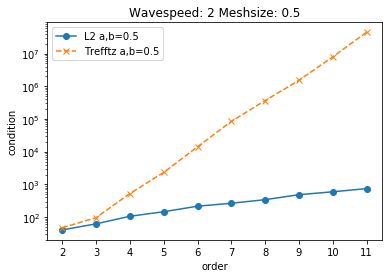

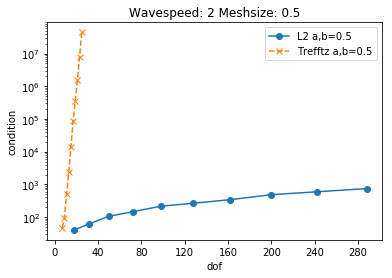

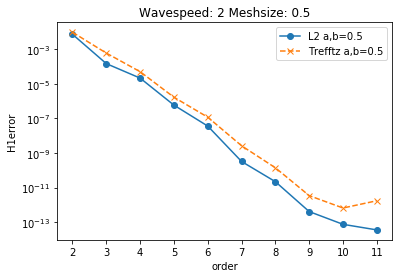

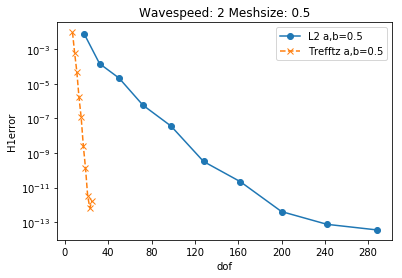

In [9]:
import scipy.special
solution = []
alpha=0.5
beta=0.5

mesh = MakeMesh()

for ordr in range(2,order):
    print("run order: " + str(ordr))

    btype = 0
    [dof,cond,L2error,sH1error] = WaveL2(ordr,truesol,v0,sig0,alpha,beta)
    solution.append([btype, ordr, dof,cond,L2error,sH1error])
    print("btype: " + 'L2' + " dof: " + str(dof) + " cond: " + str(cond) + " L2error: " + str(L2error) + " H1error: "+ str(sH1error))

    btype = 1
    [dof,cond,L2error,sH1error] = WaveTrefftz(ordr+1,0,c,truesol,v0,sig0,alpha,beta)
    solution.append([btype,ordr,dof,cond,L2error,sH1error])
    print("btype: " + 'Trefftz' + " dof: " + str(dof) + " cond: " + str(cond) + " L2error: " + str(L2error) + " H1error: "+ str(sH1error))
    
        
data = ['condition', 'L2error', 'H1error']
sol = np.array(solution)

for i in [0,2]:
    errfig(sol,1,i+3,'order',"results/pvt_"+data[i]+".png")
    errfig(sol,2,i+3,'dof',"results/pvtdof_"+data[i]+".png")